In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from datetime import date
print(date.today())

2025-12-07


In [8]:
workdir = '/mnt/disk7t/xwj/axolotl_rev'
datasetdir = f'{workdir}/dataset_nc2017kremer'

os.chdir(datasetdir)
# level 1
output_path = f'{workdir}/result/dataset_nc2017kremer'
# level 2
samples_path = f'{output_path}/samples'
task_config_path = f'{output_path}/task_config'
task_output_path = f'{output_path}/task_output'
metric_output_path = f'{output_path}/metric'

In [7]:
pwd

'/mnt/disk7t/xwj/axolotl_rev'

In [18]:
nc2017_valid6 = [('MUC1361', 'MCOLN1'),
  ('MUC1350', 'CLPP'),
  ('MUC1365', 'TIMMDC1'),
  ('MUC1344', 'TIMMDC1'),
  ('MUC1396', 'MGST1'),
  ('MUC1404', 'ALDH18A1')]


In [20]:

# sampled_configs已保存到: /mnt/disk7t/xwj/axolotl_rev/result/dataset_nc2017kremer/task_config/t01_FB_s119_g11048_nmd_sampled_configs_dict.pkl
# base_prefix = 't01_FB_s119_g11048_nmd'
# 从tissues中获取信息
use = 't00_FB_s119_g11048'
tissues = pd.read_csv(f'tissues_{use}.tsv', sep='\t', index_col=0)
tissue_data = tissues.iloc[0]
t = tissue_data[0]  # TISSUE_ID
tn = tissue_data[1]  # TISSUE_NAME
ns = tissue_data[2]  # N_SAMPLE
ng = tissue_data[3]  # N_GENE
ctsfile = tissue_data[4]  # CTS_FILE
outlierfile = tissue_data[5]  # OUTLIER_FILE

cts = pd.read_csv(ctsfile, sep='\t', index_col=0)

base_prefix = f't01_{t}_s{ns}_g{ng}_nmd' # Version2.  six valid + equal number of NMD, must in sub samples
output_file = os.path.join(task_config_path, f'{base_prefix}_sampled_configs_dict.pkl')
sampled_configs = pickle.load(open(output_file, 'rb'))


In [21]:
import numpy as np
import pandas as pd
from itertools import product

# 定义方法和打分方式的对应关系
methods_scores = {
    'OUTRIDER': ['aberrant', 'padjust',],
    'ABEILLE': ['predict', 'anomaly_score', 'delta_count', 'divergence_score'],
}

# 定义排序逻辑
score_order = {
    'anomaly_score': False,
    'delta_count': True,
    'divergence_score': True,
    'pValue': True,
    'padjust': True,
    'zScore': True
}
rank_types = ['table','sample']
# 创建多级索引，包含样本量和重复信息
index_sizes = []
sample_sizes = [100, 60, 30, 10]
n_replicates = 10  # 每个样本量重复10次
random_seeds = range(n_replicates)  # 使用0-9作为随机种子

for size in sample_sizes:
    for seed in range(n_replicates):
        # 只添加有效的组合
        for method in methods_scores.keys():
            for score in methods_scores[method]:
                for rank in rank_types:
                    index_sizes.append((f'size_{size}', f'seed_{seed}', method, score, rank))

multi_index = pd.MultiIndex.from_tuples(
    index_sizes,
    names=['Sample_Size', 'Seed', 'Method', 'Score', 'Rank_Type']
)

# 创建空的DataFrame
result_df = pd.DataFrame(columns=nc2017_valid6, index=multi_index)
result_df = result_df.sort_index()
# 填充数据
for size in sample_sizes:
    for seed in range(n_replicates):
        # 获取当前抽样的配置
        current_config = sampled_configs[f'size_{size}'][f'seed_{seed}']
        # 对每个方法处理
        for method in methods_scores.keys():
            print(size, seed, method)
            # 获取对应的原始结果
            if 'ABEILLE' in method:
                # 假设res_abeille是原始结果
                res_data = pd.read_csv(f'{current_config["output_dir"]}/000_abeille.txt.gz_raw.gz', sep='\t', index_col=0)
                res_data.index = [ (s,g) for s,g in zip(res_data['Sample'], res_data['Transcript'])]
                
                for score in methods_scores[method]:
                    if score in ['predict','aberrant']:
                        values = [ res_data[score][s_g] for s_g in nc2017_valid6 ]
                        result_df.loc[(f'size_{size}', f'seed_{seed}', method, score, slice(None)), :] = values  
                    else:
                        # score = 'anomaly_score'
                        # ABEILL rank by True/False, then by score col
                        ascend = score_order[score]
                        res_data = res_data.sort_values(by =['predict',score ], ascending=[False, ascend])
                        res_data[f'ABEILLE/{score}'] = range(1, res_data.shape[0]+1)
                        values = [res_data[f'ABEILLE/{score}'] [s_g] for s_g in nc2017_valid6 if s_g in res_data.index]
                        result_df.loc[(f'size_{size}', f'seed_{seed}', method, score, 'table'), :] = values
                        
                        res_data = res_data.sort_values(by =['Sample','predict',score ], ascending=[False, False, ascend]) 
                        res_data[f'ABEILLE/{score}_sample'] = np.tile(range(1, cts.shape[0] + 1), size)
                        values = [res_data[f'ABEILLE/{score}_sample'] [s_g] for s_g in nc2017_valid6 if s_g in res_data.index]
                        result_df.loc[(f'size_{size}', f'seed_{seed}', method, score, 'sample'), :] = values   
                        
            elif 'OUTRIDER' in method:
            
                res_data = pd.read_csv(f'{current_config["output_dir"]}/000_outrider.txt.gz_raw.gz', sep='\t', index_col=0)
                res_data.index = [ (s,g) for s,g in zip(res_data['sampleID'], res_data['geneID'])]
                
                # 假设res_outrider是原始结果
                for score in methods_scores[method]:
                    if score in ['predict','aberrant']:
                        values = [ res_data[score][s_g] for s_g in nc2017_valid6 ]
                        result_df.loc[(f'size_{size}', f'seed_{seed}', method, score, slice(None)), :] = values                    
                    else:
                        # 获取排序逻辑\计算排名, rank by score col
                        ascend = score_order[score]
                        ranks = res_data[score].rank(ascending = ascend)
                        values = [ranks[s_g] for s_g in nc2017_valid6 if s_g in ranks.index]
                        result_df.loc[(f'size_{size}', f'seed_{seed}', method, score,'table'), :] = values
                        
                        ranks = res_data.groupby('sampleID')[score].rank(ascending=ascend)
                        values = [ranks[s_g] for s_g in nc2017_valid6 if s_g in ranks.index]
                        result_df.loc[(f'size_{size}', f'seed_{seed}', method, score,'sample'), :] = values

            else:
                # other methods
                pass
if False:
    # save to pickle
    result_df.to_pickle(f'{metric_output_path}/result_df_sample_sizes_kremer_valid6.pkl')
# 显示结果
result_df


100 0 OUTRIDER
100 0 ABEILLE
100 1 OUTRIDER
100 1 ABEILLE
100 2 OUTRIDER
100 2 ABEILLE
100 3 OUTRIDER
100 3 ABEILLE
30 5 OUTRIDER
30 5 ABEILLE
30 6 OUTRIDER
30 6 ABEILLE
30 7 OUTRIDER
30 7 ABEILLE
30 8 OUTRIDER
30 8 ABEILLE
30 9 OUTRIDER
30 9 ABEILLE
10 0 OUTRIDER
10 0 ABEILLE
10 1 OUTRIDER
10 1 ABEILLE
10 2 OUTRIDER
10 2 ABEILLE
10 3 OUTRIDER
10 3 ABEILLE
10 4 OUTRIDER
10 4 ABEILLE
10 5 OUTRIDER
10 5 ABEILLE
10 6 OUTRIDER
10 6 ABEILLE
10 7 OUTRIDER
10 7 ABEILLE
10 8 OUTRIDER
10 8 ABEILLE
10 9 OUTRIDER
10 9 ABEILLE


(MUC1361, MCOLN1)  \
Sample_Size Seed   Method   Score            Rank_Type                     
size_10     seed_0 ABEILLE  anomaly_score    sample                  528   
                                             table                  5298   
                            delta_count      sample                  420   
                                             table                  6465   
                            divergence_score sample                  776   
...                                                                  ...   
size_60     seed_9 ABEILLE  predict          table                 False   
                   OUTRIDER aberrant         sample                 True   
                                             table                  True   
                            padjust          sample                  1.0   
                                             table                   3.0   

                                                       (MUC1350, CLPP)  \
Sample_Size Seed   Method   Score            Rank_Type                   
size_10     seed_0 ABEILLE  anomaly_score    sample                529   
                                             table                3796   
                            delta_count      sample               3292   
                                             table               52848   
                            divergence_score sample                371   
...                                                                ...   
size_60     seed_9 ABEILLE  predict          table               False   
                   OUTRIDER aberrant         sample               True   
                                             table                True   
                            padjust          sample                1.0   
                                             table                 5.0   

                                                       (MUC1365, TIMMDC1)  \
Sample_Size Seed   Method   Score            Rank_Type                      
size_10     seed_0 ABEILLE  anomaly_score    sample                   161   
                                             table                   3474   
                            delta_count      sample                   124   
                                             table                   2411   
                            divergence_score sample                  2300   
...                                                                   ...   
size_60     seed_9 ABEILLE  predict          table                  False   
                   OUTRIDER aberrant         sample                  True   
                                             table                   True   
                            padjust          sample                   1.5   
                                             table                   15.5   

                                                       (MUC1344, TIMMDC1)  \
Sample_Size Seed   Method   Score            Rank_Type                      
size_10     seed_0 ABEILLE  anomaly_score    sample                   258   
                                             table                   5390   
                            delta_count      sample                   235   
                                             table                   3736   
                            divergence_score sample                  3842   
...                                                                   ...   
size_60     seed_9 ABEILLE  predict          table                   True   
                   OUTRIDER aberrant         sample                 False   
                                             table                  False   
                            padjust          sample                   1.5   
                                             table                   95.5   

                                                       (MUC1396, MGST1)  \
Sample_Size Seed   Metho

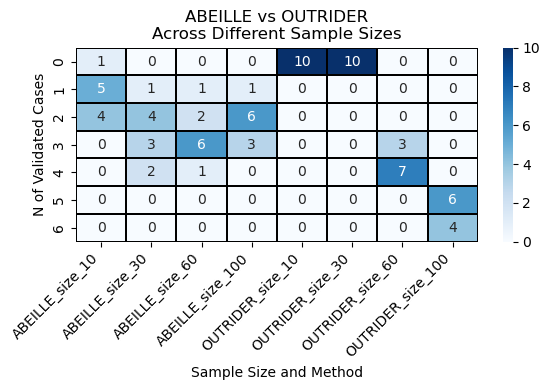

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 获取ABEILLE方法的数据 True/False 列
draw_abeille = result_df.loc[(slice(None), slice(None), 'ABEILLE', 'predict','table'), :]\
    .astype(np.int32)\
    .sum(axis=1)\
    .groupby(level='Sample_Size')\
    .value_counts()\
    .unstack(level='Sample_Size')\
    .fillna(0)\
    .loc[:, ['size_10', 'size_30', 'size_60', 'size_100']]

# 获取OUTRIDER方法的数据 True/False 列
draw_outlier = result_df.loc[(slice(None), slice(None), 'OUTRIDER', 'aberrant','table'), :]\
    .astype(np.int32)\
    .sum(axis=1)\
    .groupby(level='Sample_Size')\
    .value_counts()\
    .unstack(level='Sample_Size')\
    .fillna(0)\
    .loc[:, ['size_10', 'size_30', 'size_60', 'size_100']]

# 为每个数据集添加方法前缀
draw_abeille.columns = [f'ABEILLE_{col}' for col in draw_abeille.columns]
draw_outlier.columns = [f'OUTRIDER_{col}' for col in draw_outlier.columns]

# 横向拼接两个数据集
combined_draw = pd.concat([draw_abeille, draw_outlier], axis=1).fillna(0)
# 创建图形
plt.style.use('default')
plt.figure(figsize=(6, 4))
# 绘制heatmap
sns.heatmap(combined_draw, cmap='Blues', linecolor='black',linewidths=0.1, annot=True, fmt='g')

# 设置标题和标签
plt.title('ABEILLE vs OUTRIDER\nAcross Different Sample Sizes')
plt.xlabel('Sample Size and Method')
plt.xticks(rotation=45, ha='right') 
plt.ylabel('N of Validated Cases')

# 调整布局
plt.tight_layout()
plt.savefig(f'{workdir}/result/figure/kremer_heatmap_ABEILLE_vs_OUTRIDER_recall_validated_cases.pdf',dpi=200)
if False:
    plt.savefig(f'{metric_output_path}/heatmap_ABEILLE_vs_OUTRIDER_recall_validated_cases.pdf',dpi=200)

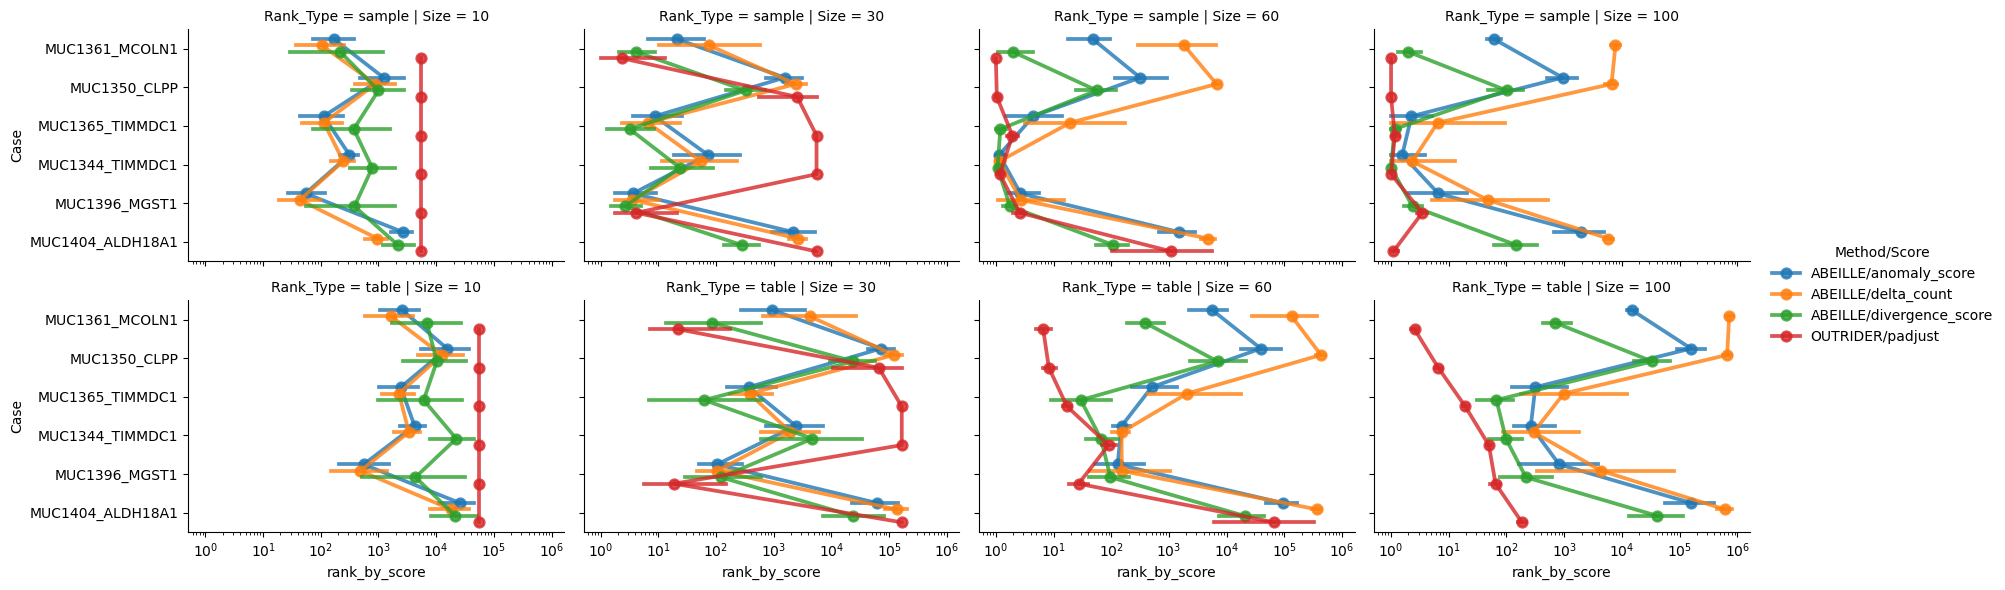

In [27]:
plt.style.use('default')
draw = result_df.query('(Score not in ["predict", "aberrant"])')# & (Sample_Size == "size_100")')
draw.columns.name = 'Rank'
draw = draw.stack().reset_index().rename(columns = {0:'rank_by_score', 'level_4':'Sample_Gene'})
draw['Case'] = [ f'{s}_{g}'  for s,g in draw['Rank'] ]
draw['Method/Score'] = [ f'{mt}/{sc}' for mt,sc in zip(draw['Method'], draw['Score']) ]
draw['Size'] = [ np.int32(x.split('_')[-1]) for x in draw['Sample_Size']]
# sns.boxplot(draw, x='Score', y='value', hue='Method')
sns.catplot(data=draw, y='Case', x='rank_by_score', kind='point', dodge=0.5, alpha=0.8, hue='Method/Score', 
            col='Size', row = 'Rank_Type',
            palette='tab10',log_scale=True, orient='h', height=3, aspect=1.5 )
plt.savefig(f'{workdir}/result/figure/kremer_boxplot_ABEILLE_vs_OUTRIDER_rank_validated_cases_simple.pdf',dpi=200)
# plt.savefig(f'{metric_output_path}/boxplot_ABEILLE_vs_OUTRIDER_rank_validated_cases_simple.pdf',dpi=200)

In [28]:
# 非空的元素
draw_methods = [
    # 'f0.1L20',
    'ABEILLE/anomaly_score', 
    'ABEILLE/delta_count', 
    'ABEILLE/divergence_score', 
    'OUTRIDER/padjust', 
    'OUTSINGLE'
]
name_prefix = 't01_FB_s119_g11048_nmd'
n_replicates = 10
sample_sizes = [ 10, 30,  60, 100, ]# [100, 60, 30, 10]

# auprc = pd.DataFrame(index=sample_sizes, columns=draw_methods)
myindex = pd.MultiIndex.from_tuples([ (size, k) for size in sample_sizes for k in range(n_replicates) ],names=['size', 'seed'])
auprc =  pd.DataFrame(index= myindex, columns=draw_methods, dtype=np.float32) 

buffer = []
for i, size in enumerate(sample_sizes):
    # t  = row.TISSUE_ID
    # tn = row.TISSUE_NAME
    
    # file = f'{metric_output_path}/t{i:02d}_{t}_auprc.pkl' # 改成需要的后缀 OUTRIDER_dim!
    file = f'{metric_output_path}/{name_prefix}_size_{size}_auprc.pkl'
    with open(file,'rb') as f:
        data_load = pickle.load(f)
    _t, _tn, _i, dict_auprc, dict_curve = data_load[0], data_load[1], data_load[2], data_load[3], data_load[4]
    
    for k in range(n_replicates):
        auprc.loc[(size, k) ,:] = [ dict_auprc[k][m][0] for m in draw_methods ]

        for m in draw_methods:
            if m.startswith('OUTRIDER'):
                # print(m) 
                curve = dict_curve[k][m][0].drop_duplicates().copy()
                aberrant = 'aberrant'
                mask = curve[aberrant] == True
                # print( curve.loc[mask,].tail(1) )
                
            if m.startswith('OUTSINGLE'):
                # print(m) 
                continue
                curve = dict_curve['all'][m][0].drop_duplicates().copy()
                print( curve.query('pred < 0.05').tail(1))
                # break
            if m.startswith('ABEILLE'):
                # print(m)
                curve = dict_curve[k][m][0].drop_duplicates().copy()
                aberrant = 'predict'
                mask = curve[aberrant] == True
                
            if mask.any():
                # print( curve.loc[mask,].tail(1) )
                buffer.append({
                    'Method': m,
                    'SIZE': size,
                    'replicate': k,
                    'N_Recall': curve[mask]['label'].sum(),
                    'Precision':curve[mask]['precision'].values[-1],
                    'Recall': curve[mask]['recall'].values[-1],
                })
            else:
                buffer.append({
                    'Method': m,
                    'SIZE': size,
                    'replicate': k,
                    'N_Recall': 0,
                    'Precision': 0,
                    'Recall': 0,
                })
                # print( dict_curve['all'][m][0].query('@aberrant == True').tail(1) )
df_class_recall  = pd.DataFrame(buffer) 

In [36]:
df_out= df_class_recall.drop(columns = ['replicate']).groupby(['Method', 'SIZE']).mean()
# kremer_ABEILLE_vs_OUTRIDER_recall_precision_validated_cases
# table output
df_out.to_excel(f'{workdir}/result/table/response_kremer119_outlier28_recall_precision.xlsx', 
            sheet_name='response_kremer119_table1',index=True)

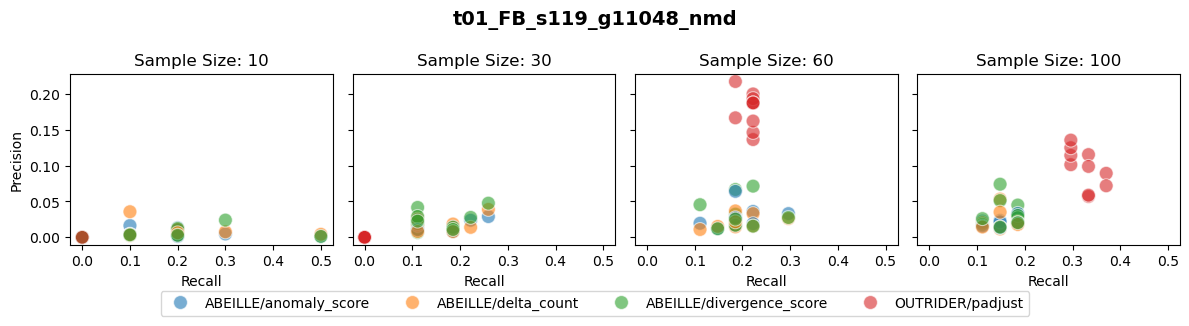

In [39]:
fig, axes = plt.subplots(1, len(sample_sizes), figsize=(3*len(sample_sizes), 3), sharey=True, sharex=True )
for i, size in enumerate(sample_sizes):

    draw = df_class_recall.query(f'SIZE == {size}')

    sns.scatterplot(
        data=draw,
        x = 'Recall',y ='Precision', hue='Method',s=100,
        palette='tab10',
        ax=axes[i],
        alpha=0.6,
    )
    axes[i].set_title(f'Sample Size: {size}')

    axes[i].get_legend().remove()

# 2. 用最后一根轴的“handles/labels”生成 Figure 级图例
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels,
        loc='center',           # 居中
        bbox_to_anchor=(0.5, 0),  # 放在底部（微调 0.02）
        ncol=len(labels),       # 横向排列
        frameon=True)

# 给图例留一点底部空间
fig.subplots_adjust(bottom=0)
fig.suptitle(name_prefix, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{workdir}/result/figure/kremer_scatter_ABEILLE_vs_OUTRIDER_recall_precision_validated_cases.pdf',bbox_inches='tight', dpi=200)